In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

### 1. Define the Neural Network Architecture

In [3]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

### 2. Define the PDE, Domain, and Exact Solution

In [4]:
# Define the parameters from the paper
epsilon = 0.1
beta = [0, 0, 0.5]
gamma = 1.0

# Source term f(x,y,z) derived from the exact solution, now using torch
def f_term(x, y, z, u):
    f = (2 / (np.sqrt(epsilon) * np.pi)) * x * y * z * (1 / (1 + z**2 / epsilon))**2 + \
        beta[0] * (y / np.pi * torch.atan(z / np.sqrt(epsilon))) + \
        beta[1] * (x / np.pi * torch.atan(z / np.sqrt(epsilon))) + \
        beta[2] * (x * y / (np.sqrt(epsilon) * np.pi * (1 + z**2 / epsilon))) + \
        gamma * u
    return f

# This function calculates the PDE residual using PyTorch's autograd
def pde_residual(net, x, y, z):
    u = net(torch.cat([x, y, z], dim=1))
    
    # First derivatives
    u_grads = torch.autograd.grad(u, [x, y, z], grad_outputs=torch.ones_like(u), create_graph=True)
    u_x = u_grads[0]
    u_y = u_grads[1]
    u_z = u_grads[2]

    # Second derivatives (Laplacian)
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    u_zz = torch.autograd.grad(u_z, z, grad_outputs=torch.ones_like(u_z), create_graph=True)[0]
    
    laplacian = u_xx + u_yy + u_zz
    convection = beta[0]*u_x + beta[1]*u_y + beta[2]*u_z
    
    source = f_term(x, y, z, u)
    
    return -epsilon * laplacian + convection + gamma * u - source

# Define the exact solution using numpy for final plotting and comparison
def exact_solution_np(x, y, z):
    return (x * y / np.pi) * np.arctan(z / np.sqrt(epsilon))

In [5]:
# Instantiate the network and initialize weights
pinn_net = FNN()
pinn_net.apply(init_weights)

# Define the optimizer
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=5e-4)

# Generate training data points
num_domain_points = 8000
num_boundary_points = 2000

# Domain points (collocation points)
domain_points = torch.rand(num_domain_points, 3)
domain_points.requires_grad = True # Important for calculating derivatives

# Boundary points
# We generate points on each of the 6 faces of the cube
bp_per_face = num_boundary_points // 6
faces = []
for i in range(3):
    for val in [0, 1]:
        points = torch.rand(bp_per_face, 3)
        points[:, i] = val
        faces.append(points)
boundary_points = torch.cat(faces, dim=0)

# Get the true values at the boundary points from the exact solution
x_bc, y_bc, z_bc = boundary_points[:,0:1], boundary_points[:,1:2], boundary_points[:,2:3]
u_bc_exact = torch.tensor(exact_solution_np(x_bc.numpy(), y_bc.numpy(), z_bc.numpy()), dtype=torch.float32)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [15:06<00:00,  5.52it/s]


Iteration 5000, Loss: 2.2185e-05


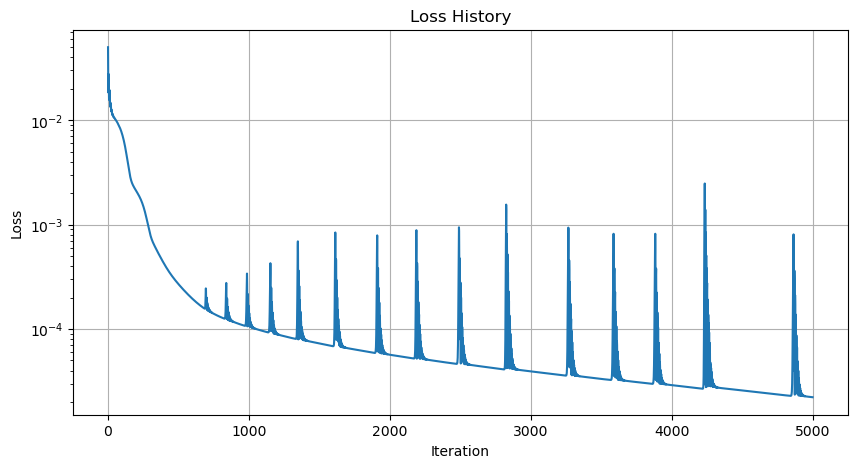

In [5]:
iterations = 5000
loss_history = []

for i in tqdm(range(iterations)):
    optimizer.zero_grad()
    
    # 1. Calculate PDE Loss (Loss inside the domain)
    x_d, y_d, z_d = domain_points[:,0:1], domain_points[:,1:2], domain_points[:,2:3]
    pde_res = pde_residual(pinn_net, x_d, y_d, z_d)
    loss_pde = torch.mean(pde_res**2)
    
    # 2. Calculate Boundary Condition Loss
    u_bc_pred = pinn_net(boundary_points)
    loss_bc = torch.mean((u_bc_pred - u_bc_exact)**2)
    
    # 3. Combine losses (we can weight them if needed, here we use 1:1)
    total_loss = loss_pde + loss_bc
    loss_history.append(total_loss.item())
    
    # 4. Backpropagate and update weights
    total_loss.backward()
    optimizer.step()
    
    if (i + 1) % 5000 == 0:
        print(f"Iteration {i+1}, Loss: {total_loss.item():.4e}")

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.yscale('log')
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# Generate a grid of points for plotting
x_plot = np.linspace(0, 1, 100)
y_plot = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_plot, y_plot)
Z = np.full(X.shape, 0.5) 

plot_points_np = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T
plot_points_torch = torch.tensor(plot_points_np, dtype=torch.float32)

# Get the exact solution and the PINN prediction
u_exact = exact_solution_np(X, Y, Z)

pinn_net.eval() # Set the model to evaluation mode
with torch.no_grad():
    u_pred = pinn_net(plot_points_torch).numpy().reshape(X.shape)

# Calculate the absolute error
abs_error = np.abs(u_exact - u_pred)

# Create the plots
fig = plt.figure(figsize=(18, 5))

# Plot Exact Solution
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, u_exact, cmap='viridis')
ax1.set_title('Exact Solution at z=0.5')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('u')

# Plot PINN Prediction
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, u_pred, cmap='viridis')
ax2.set_title('PINN Prediction at z=0.5')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('u')

# Plot Absolute Error
ax3 = fig.add_subplot(133, projection='3d')
surf = ax3.plot_surface(X, Y, abs_error, cmap='hot')
ax3.set_title('Absolute Error |u_exact - u_pinn|')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('Error')
fig.colorbar(surf)

plt.tight_layout()
plt.show()

# Print the final L2 relative error
final_error = np.linalg.norm(u_exact - u_pred) / np.linalg.norm(u_exact)
print(f"Final L2 relative error: {final_error:.4e}")